# Import the libraries

In [1]:
# Importing libraries
from tqdm import tqdm
import torch
from sklearn.preprocessing import LabelEncoder
from transformers import (
    AutoModelForImageClassification,
    ViTFeatureExtractor,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
)
from datasets import load_dataset
from peft import LoraConfig, TaskType, get_peft_model, prepare_model_for_kbit_training
import evaluate
import numpy as np
import warnings
import os

from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
import pandas as pd 

import matplotlib.pyplot as plt
from utils import plot_metrics, gather_metrics

# Set warnings to ignore to keep output clean
warnings.filterwarnings('ignore')

/home/rft38/.conda/envs/ML-6784/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [80]:
# We will be looking at the two following datasets: MNIST and Oxford IIIT Pets 
# Other potential datasets: FGVC Aircraft, caltech-101, food101, flowers-102
mnist_dataset = load_dataset("mnist")
oxford_pet_dataset = load_dataset("visual-layer/oxford-iiit-pet-vl-enriched")
stanford_dogs_dataset = load_dataset("amaye15/stanford-dogs")

num_mnist_classes, num_oxford_pet_classes, num_stanford_dogs_classes = 10, 37, 120

# Choosing dataset which we will train on and creating val/train split
dataset = stanford_dogs_dataset
dataset = dataset["train"].train_test_split(test_size=0.15, shuffle=True, seed=1)
train_dataset = dataset['train']
val_dataset = dataset['test']

num_classes = num_stanford_dogs_classes

In [81]:
image_col_name = "pixel_values" # "image" for oxford-pet

# Preprocessing dataset to be compatible with ViT
transform = Compose([
    Resize((224, 224)),
    ToTensor()
])

# Combined function to resize, convert to RGB, and then to tensor
def preprocess_images(batch):
    batch['pixel_values'] = [transform(image.convert("RGB")) for image in batch[image_col_name]]
    if image_col_name!='pixel_values':
        del batch[image_col_name]
    return batch

# Apply resizing
train_dataset = train_dataset.map(preprocess_images, batched=True)
val_dataset = val_dataset.map(preprocess_images, batched=True)

In [ ]:
# Preprocessing for the labels -> For now only needed for Oxford pet dataset
label_encoder = LabelEncoder()
label_column_name = 'label_breed'

def label_preprocessing(dataset):
    # Fit the encoder on the string labels and transform them to integer labels
    label_encoder.fit(dataset[label_column_name])
    encoded_labels = label_encoder.transform(dataset[label_column_name])

    # Add the encoded labels as a new column in the dataset
    return dataset.add_column('label', encoded_labels)

# Apply preprocessing
train_dataset = label_preprocessing(train_dataset)
val_dataset = label_preprocessing(val_dataset)

In [82]:
# Whether to use LoRA or not
apply_LoRA = False

# LoRA hyper parameters
LoRA_r = 64
LORA_a = 8
LORA_dropout = 0.1

layers = ["query", "key", "value"]
target_modules = [f"vit.encoder.layer.{i}.attention.attention.{layer}" for i in range(0, 12) for layer in layers]

# Effective batch size = per_device_batch_size * gradient_accumulation_steps
per_device_batch_size = 8
gradient_accumulation_steps = 2

# Set up LoRA configuration
lora_config = LoraConfig(
    r=LoRA_r,
    lora_alpha=LORA_a,
    target_modules=target_modules,
    lora_dropout=LORA_dropout,
    use_rslora=True,
)

# Load model and tokenizer
model_name = "google/vit-base-patch16-224" 
model = AutoModelForImageClassification.from_pretrained(model_name, num_labels = num_classes, ignore_mismatched_sizes=True)
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name) if model_name else None

# Apply LoRA to the model
if apply_LoRA:
    model = get_peft_model(model, lora_config)

# Move model to GPU
model = model.to("cuda")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([120]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([120, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define accuracy metric
accuracy = evaluate.load("accuracy")

# Define the compute_metrics function to calculate accuracy
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)

run_name = "ViT_pet"
training_args = TrainingArguments(
    output_dir=f"results/{run_name}",
    per_device_train_batch_size=per_device_batch_size,
    per_device_eval_batch_size=per_device_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    max_steps=500,
    logging_steps=20,
    eval_steps=20,
    save_steps=50,
    save_total_limit=1,
    evaluation_strategy="steps"
)


# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Start training
trainer.train()

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss,Validation Loss


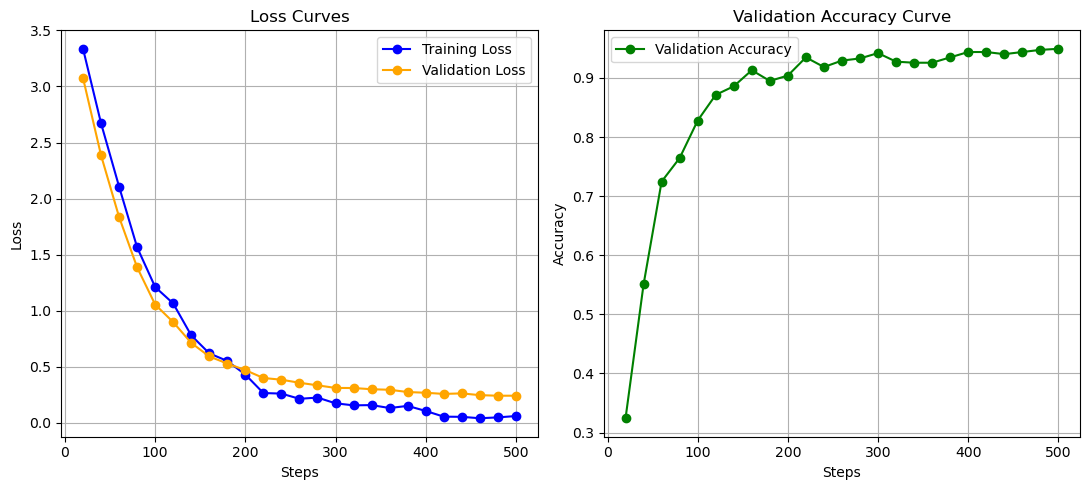

In [ ]:
# Gather data from trainer and plot
data = gather_metrics(trainer)
plot_metrics(data)